In [1]:
import dask
import pystac_client
import planetary_computer as pc
import stackstac
import dask.array as da
import matplotlib.pyplot as plt

### Dask cluster ###

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/fkordi@clarku.edu/proxy/8787/status,
Dashboard: /user/fkordi@clarku.edu/proxy/8787/status,Workers: 4
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40273,Workers: 4
Dashboard: /user/fkordi@clarku.edu/proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:45417,Total threads: 2
Dashboard: /user/fkordi@clarku.edu/proxy/35797/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:45491,


In [3]:
# collection that intersects with the following bbox
bbox = (35.16402630997399, 11.240162235950265, 35.17440912681519, 11.249823496541282)

In [4]:
catalog = pystac_client.Client.open('https://earth-search.aws.element84.com/v1')

search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox,
    datetime=["2017-01-01", "2022-12-31"],
    query=["eo:cloud_cover<50"]
)

In [5]:
items = search.item_collection()
len(items)

349

In [6]:
%%time
items = pc.sign(search)
len(items)

CPU times: user 1.1 s, sys: 40.3 ms, total: 1.14 s
Wall time: 1.12 s


349

In [7]:
%%time
stack = stackstac.stack(items, bounds_latlon=bbox, assets=["green", "nir"])
stack

CPU times: user 149 ms, sys: 2.71 ms, total: 152 ms
Wall time: 147 ms


/srv/conda/envs/notebook/lib/python3.11/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<xarray.DataArray 'stackstac-cd31071f39965ed3506336b7b0d8b795' (time: 349,
                                                                band: 2,
                                                                y: 109, x: 115)>
dask.array<fetch_raster_window, shape=(349, 2, 109, 115), dtype=float64, chunksize=(1, 1, 109, 115), chunktype=numpy.ndarray>
Coordinates: (12/54)
  * time                                     (time) datetime64[ns] 2017-01-05...
    id                                       (time) <U24 'S2A_36PYT_20170105_...
  * band                                     (band) <U5 'green' 'nir'
  * x                                        (x) float64 7.362e+05 ... 7.374e+05
  * y                                        (y) float64 1.244e+06 ... 1.243e+06
    s2:datastrip_id                          (time) <U64 'S2A_OPER_MSI_L2A_DS...
    ...                                       ...
    gsd                                      int64 10
    proj:shape                               object {10980}
    common_name                              (band) <U5 'green' 'nir'
    center_wavelength                        (band) float64 0.56 0.842
    full_width_half_max                      (band) float64 0.045 0.145
    epsg                                     int64 32636
Attributes:
    spec:        RasterSpec(epsg=32636, bounds=(736250.0, 1243400.0, 737400.0...
    crs:         epsg:32636
    transform:   | 10.00, 0.00, 736250.00|\n| 0.00,-10.00, 1244490.00|\n| 0.0...
    resolution:  10.0

In [8]:
# Band names are not trivial from the initial query
stack.band

<xarray.DataArray 'band' (band: 2)>
array(['green', 'nir'], dtype='<U5')
Coordinates: (12/20)
  * band                                     (band) <U5 'green' 'nir'
    proj:epsg                                int64 32636
    grid:code                                <U10 'MGRS-36PYT'
    instruments                              <U3 'msi'
    s2:saturated_defective_pixel_percentage  int64 0
    mgrs:grid_square                         <U2 'YT'
    ...                                       ...
    gsd                                      int64 10
    proj:shape                               object {10980}
    common_name                              (band) <U5 'green' 'nir'
    center_wavelength                        (band) float64 0.56 0.842
    full_width_half_max                      (band) float64 0.045 0.145
    epsg                                     int64 32636

In [9]:
# Use common_name for bands
stack = stack.assign_coords(band=stack.common_name.fillna(stack.band).rename("band"))
stack.band

<xarray.DataArray 'band' (band: 2)>
array(['green', 'nir'], dtype='<U5')
Coordinates: (12/20)
  * band                                     (band) <U5 'green' 'nir'
    proj:epsg                                int64 32636
    grid:code                                <U10 'MGRS-36PYT'
    instruments                              <U3 'msi'
    s2:saturated_defective_pixel_percentage  int64 0
    mgrs:grid_square                         <U2 'YT'
    ...                                       ...
    gsd                                      int64 10
    proj:shape                               object {10980}
    common_name                              (band) <U5 'green' 'nir'
    center_wavelength                        (band) float64 0.56 0.842
    full_width_half_max                      (band) float64 0.045 0.145
    epsg                                     int64 32636

In [10]:
green = stack.sel(band="green")
nir = stack.sel(band="nir")

In [11]:
green

<xarray.DataArray 'stackstac-cd31071f39965ed3506336b7b0d8b795' (time: 349,
                                                                y: 109, x: 115)>
dask.array<getitem, shape=(349, 109, 115), dtype=float64, chunksize=(1, 109, 115), chunktype=numpy.ndarray>
Coordinates: (12/54)
  * time                                     (time) datetime64[ns] 2017-01-05...
    id                                       (time) <U24 'S2A_36PYT_20170105_...
    band                                     <U5 'green'
  * x                                        (x) float64 7.362e+05 ... 7.374e+05
  * y                                        (y) float64 1.244e+06 ... 1.243e+06
    s2:datastrip_id                          (time) <U64 'S2A_OPER_MSI_L2A_DS...
    ...                                       ...
    gsd                                      int64 10
    proj:shape                               object {10980}
    common_name                              <U5 'green'
    center_wavelength                        float64 0.56
    full_width_half_max                      float64 0.045
    epsg                                     int64 32636
Attributes:
    spec:        RasterSpec(epsg=32636, bounds=(736250.0, 1243400.0, 737400.0...
    crs:         epsg:32636
    transform:   | 10.00, 0.00, 736250.00|\n| 0.00,-10.00, 1244490.00|\n| 0.0...
    resolution:  10.0

In [12]:
nir

<xarray.DataArray 'stackstac-cd31071f39965ed3506336b7b0d8b795' (time: 349,
                                                                y: 109, x: 115)>
dask.array<getitem, shape=(349, 109, 115), dtype=float64, chunksize=(1, 109, 115), chunktype=numpy.ndarray>
Coordinates: (12/54)
  * time                                     (time) datetime64[ns] 2017-01-05...
    id                                       (time) <U24 'S2A_36PYT_20170105_...
    band                                     <U5 'nir'
  * x                                        (x) float64 7.362e+05 ... 7.374e+05
  * y                                        (y) float64 1.244e+06 ... 1.243e+06
    s2:datastrip_id                          (time) <U64 'S2A_OPER_MSI_L2A_DS...
    ...                                       ...
    gsd                                      int64 10
    proj:shape                               object {10980}
    common_name                              <U5 'nir'
    center_wavelength                        float64 0.842
    full_width_half_max                      float64 0.145
    epsg                                     int64 32636
Attributes:
    spec:        RasterSpec(epsg=32636, bounds=(736250.0, 1243400.0, 737400.0...
    crs:         epsg:32636
    transform:   | 10.00, 0.00, 736250.00|\n| 0.00,-10.00, 1244490.00|\n| 0.0...
    resolution:  10.0

In [13]:
def ndwi(green, nir):
    return (green - nir) / (green + nir)

ndwi_stack = ndwi(green, nir)

In [14]:
ndwi_stack

<xarray.DataArray 'stackstac-cd31071f39965ed3506336b7b0d8b795' (time: 349,
                                                                y: 109, x: 115)>
dask.array<truediv, shape=(349, 109, 115), dtype=float64, chunksize=(1, 109, 115), chunktype=numpy.ndarray>
Coordinates: (12/49)
  * time                                     (time) datetime64[ns] 2017-01-05...
    id                                       (time) <U24 'S2A_36PYT_20170105_...
  * x                                        (x) float64 7.362e+05 ... 7.374e+05
  * y                                        (y) float64 1.244e+06 ... 1.243e+06
    s2:datastrip_id                          (time) <U64 'S2A_OPER_MSI_L2A_DS...
    earthsearch:s3_path                      (time) <U80 's3://sentinel-cogs/...
    ...                                       ...
    s2:dark_features_percentage              (time) float64 1.918 ... 0.4553
    s2:mgrs_tile                             (time) object None None ... None
    proj:transform                           object {0, 10, 1300020, -10, 699...
    gsd                                      int64 10
    proj:shape                               object {10980}
    epsg                                     int64 32636

In [15]:
mean_ndwi = ndwi_stack.mean(dim=["x", "y"])

In [16]:
mean_ndwi

<xarray.DataArray 'stackstac-cd31071f39965ed3506336b7b0d8b795' (time: 349)>
dask.array<mean_agg-aggregate, shape=(349,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates: (12/47)
  * time                                     (time) datetime64[ns] 2017-01-05...
    id                                       (time) <U24 'S2A_36PYT_20170105_...
    s2:datastrip_id                          (time) <U64 'S2A_OPER_MSI_L2A_DS...
    earthsearch:s3_path                      (time) <U80 's3://sentinel-cogs/...
    s2:processing_baseline                   (time) <U5 '00.01' ... '05.09'
    proj:epsg                                int64 32636
    ...                                       ...
    s2:dark_features_percentage              (time) float64 1.918 ... 0.4553
    s2:mgrs_tile                             (time) object None None ... None
    proj:transform                           object {0, 10, 1300020, -10, 699...
    gsd                                      int64 10
    proj:shape                               object {10980}
    epsg                                     int64 32636

(-1.0, 1.0)

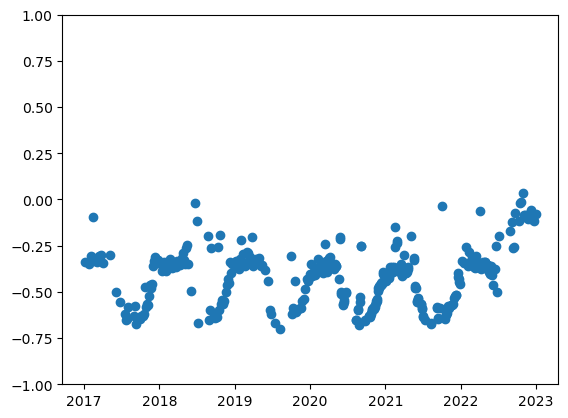

In [17]:
fig,ax = plt.subplots()
ax.scatter(x=mean_ndwi.time, y=mean_ndwi)
ax.set_ylim(-1,1)